This file merges together homeless shelter data and the children, youth, and families demographic data. It generates an event-level dataset for the homeless shelter data, with the children, youth, and families demographic data added in.

I then create a few visualizations to help understand this data.

In [1]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('datapath.txt', 'r') as f:
    datapath = f.readlines()[0].strip()

In [3]:
cyf_path = 'CYF Active 2010 to 2016-11-09(1).csv'

In [4]:
cyf = pd.read_csv(datapath + foster_care_path, usecols=['MCI_ID'])

In [7]:
homeless_path = 'HomelessShelters(1).csv'

In [3]:
%ls $datapath

Behavioral Health Services.csv        HomelessShelters(1).csv
CYF Active 2010 to 2016-11-09(1).csv  IDS Variables.xlsx
CYF Active 2010 to 2016-11-09.csv     rp_placements_clean.csv


In [4]:
behavioral_path = 'Behavioral Health Services.csv'

In [5]:
placement_path = 'rp_placements_clean.csv'

In [6]:
homeless = pd.read_csv(datapath + homeless_path, usecols='MCI_ID_OR_HMIS_CLIENT_ID')
behavioral = pd.read_csv(datapath + behavioral_path, usecols='MCI_UNIQ_ID')

NameError: name 'homeless_path' is not defined

Drop CL_ID, should be redundent. Maybe could help merge with other datasets?

In [7]:
foster_care.drop('CL_ID', axis=1, inplace=True)

A bunch of the MCI_ID are zero. This seems to be a wastebasket MCI id

In [8]:
foster_care[foster_care['MCI_ID'] == 0].shape

(6859, 8)

In [9]:
foster_care = foster_care[foster_care['MCI_ID'] > 0.0]

Data dictionary says "Ignore IDs that are less than 10 digits -- those are source system and you will not be able to link". I'm just dropping them.

In [10]:
homeless = homeless[homeless['MCI_ID_OR_HMIS_CLIENT_ID'] >= 1e9]

### Merging in demographic info 

The demographic columns (Birth date, gender, and race) are individual specific and consistent for each entry of the individual. That info is really easy to merge.

In [11]:
demographic_col = [u'BRTH_DT', u'GENDER', u'RACE']

This is an individual-based table of the three demographic factors.

In [12]:
demo_lookup = pd.DataFrame([foster_care.groupby('MCI_ID')[i].unique().map(lambda x: x[0])
                            for i in demographic_col], index=demographic_col).T #There has to be a more pythonic way of doing this

I did an inner join, so I'm going to just have the people that have interacted both with CYF and the shelter system.

This creates a homeless event level dataframe.

In [13]:
homeless_joined = homeless.join(demo_lookup, on='MCI_ID_OR_HMIS_CLIENT_ID', how='inner')

I didn't convert the dates yet...

In [14]:
dt_episode_start = pd.to_datetime(homeless_joined['PROJ_INVOLVEMENT_EPISODE_START'], errors='coerce')
dt_birth_date = pd.to_datetime(homeless_joined['BRTH_DT'], errors='coerce')

And now I can find the age in years when the homeless episode started.

In [36]:
homeless_joined['age_at_episode_start'] = ((dt_episode_start
                                     - dt_birth_date).dt.days / 365)

In [38]:
homeless_joined['GENDER'].unique()

array(['Female', 'Male'], dtype=object)

In [60]:
homeless.groupby('HUD_PROJECT_TYPE')['PROJ_INVOLVEMENT_EPISODE_START'].count() / homeless.shape[0]

HUD_PROJECT_TYPE
Bridge Housing                                                                  0.032338
CMI Bridge                                                                      0.000693
CYF Rental Assist                                                               0.126349
Case Management - HAP                                                           0.032206
Day Shelter                                                                     0.003432
ESG: Homeless Prevention                                                        0.025078
Emergency Shelter                                                               0.290711
HAP Rental Assistance                                                           0.020525
Homelessness Prevention                                                         0.006798
Innovative Program                                                              0.013496
PATH Contingency Funds                                                          0.000132
PATH

In [61]:
homeless_joined.groupby('HUD_PROJECT_TYPE')['PROJ_INVOLVEMENT_EPISODE_START'].count() / homeless_joined.shape[0]

HUD_PROJECT_TYPE
Bridge Housing                                                                  0.032695
CYF Rental Assist                                                               0.163017
Case Management - HAP                                                           0.029045
Day Shelter                                                                     0.000608
ESG: Homeless Prevention                                                        0.019009
Emergency Shelter                                                               0.247719
HAP Rental Assistance                                                           0.006235
Homelessness Prevention                                                         0.001369
Innovative Program                                                              0.024179
PATH Contingency Funds                                                          0.000152
PATH SSO Linkage                                                                0.001977
PATH

In [58]:
homeless_joined['HUD_PROJECT_TYPE'].unique()

array(['CYF Rental Assist', 'Emergency Shelter', 'PATH Street Outreach',
       'Services Only (SSO)', 'Bridge Housing',
       'Permanent Housing (e.g., Mod Rehab SRO, subsidized housing without services)',
       'Permanent Supportive Housing', 'Innovative Program',
       'Case Management - HAP', 'ESG: Homeless Prevention',
       'Rapid Re-Housing', 'Transitional Housing', 'Penn Free Bridge',
       'HAP Rental Assistance', 'Street Outreach', 'Shelter + Care',
       'Rapid Re-Housing Demo', 'PATH Contingency Funds',
       'Homelessness Prevention', 'PATH SSO Linkage', 'Safe Haven',
       'Day Shelter'], dtype=object)

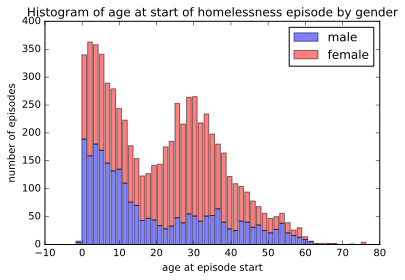

In [56]:
females = homeless_joined[homeless_joined['GENDER'] == 'Female']
males = homeless_joined[homeless_joined['GENDER'] == 'Male']
plt.hist([males['age_at_episode_start'].dropna(),
          females['age_at_episode_start'].dropna()],
         color=['blue', 'red'], label=['male', 'female'],
         stacked=True, bins=50, alpha=0.5)
plt.xlabel('age at episode start')
plt.ylabel('number of episodes')
title = 'Histogram of age at start of homelessness episode by gender'
plt.title(title)
plt.legend(loc='upper right')
plt.savefig(title.strip() + '.png')
plt.show()


In [62]:
homeless = homeless.join(demo_lookup, on='MCI_ID_OR_HMIS_CLIENT_ID', how='left')

In [65]:
not_cyf_homeless = homeless[~homeless.MCI_ID_OR_HMIS_CLIENT_ID.isin(foster_care['MCI_ID'].unique())]

In [71]:
pd.to_datetime(not_cyf_homeless['PROJ_INVOLVEMENT_EPISODE_START'], errors='coerce').describe()

count                   23726
unique                   1707
top       2013-11-12 00:00:00
freq                      114
first     2001-07-01 00:00:00
last      2016-11-15 00:00:00
Name: PROJ_INVOLVEMENT_EPISODE_START, dtype: object

In [72]:
pd.to_datetime(homeless_joined['PROJ_INVOLVEMENT_EPISODE_START'], errors='coerce').describe()

count                    6575
unique                   1165
top       2016-07-25 00:00:00
freq                       40
first     2005-05-01 00:00:00
last      2016-11-08 00:00:00
Name: PROJ_INVOLVEMENT_EPISODE_START, dtype: object

In [66]:
not_cyf_homeless.groupby('HUD_PROJECT_TYPE')['PROJ_INVOLVEMENT_EPISODE_START'].count() / not_cyf_homeless.shape[0]

HUD_PROJECT_TYPE
Bridge Housing                                                                  0.032239
CMI Bridge                                                                      0.000885
CYF Rental Assist                                                               0.116187
Case Management - HAP                                                           0.033082
Day Shelter                                                                     0.004214
ESG: Homeless Prevention                                                        0.026761
Emergency Shelter                                                               0.302625
HAP Rental Assistance                                                           0.024485
Homelessness Prevention                                                         0.008302
Innovative Program                                                              0.010536
PATH Contingency Funds                                                          0.000126
PATH